1. Initial settings

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!/opt/bin/nvidia-smi
!nvcc --version
from fastai.vision import *
from fastai.vision.interpret import *
from fastai.callbacks.hooks import *
from pathlib import Path
from fastai.utils.mem import *
torch.backends.cudnn.benchmark=True
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")
from google.colab import drive
drive.mount('/content/gdrive')

/bin/bash: /opt/bin/nvidia-smi: No such file or directory
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


2. Preparing the data

(array([288, 352]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [2, 2, 2,  ..., 0, 0, 0],
          [2, 2, 2,  ..., 0, 0, 0],
          [2, 2, 2,  ..., 0, 0, 0]]]))

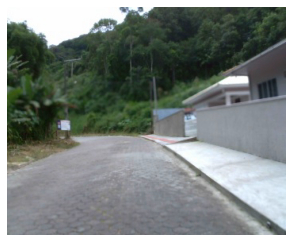

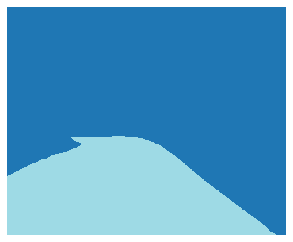

In [ ]:
path = Path('/content/gdrive/MyDrive/Colab Notebooks/data')
path.ls()
codes = np.loadtxt(path/'codes.txt', dtype=str); codes
path_lbl = path/'labels'
path_img = path/'images'
fnames = get_image_files(path_img)
fnames[:3]
len(fnames)
lbl_names = get_image_files(path_lbl)
lbl_names[:3]
len(lbl_names)
img_f = fnames[139]
img = open_image(img_f)
img.show(figsize=(5,5))
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)
src_size = np.array(mask.shape[1:])
src_size,mask.data

3. First Step - Without weights

3.1. First step Datasets

using bs=8, have 11438MB of GPU RAM free


/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:859.)
  return _solve_func(B,A)[0][:,0]


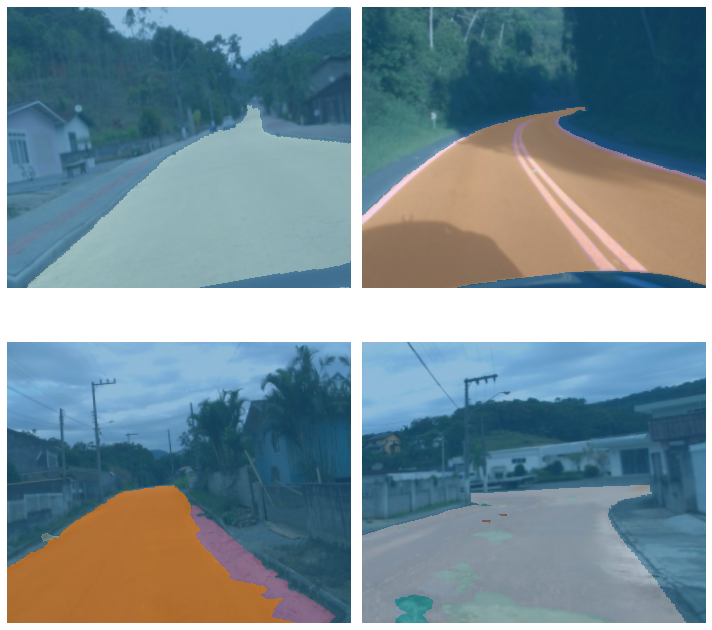

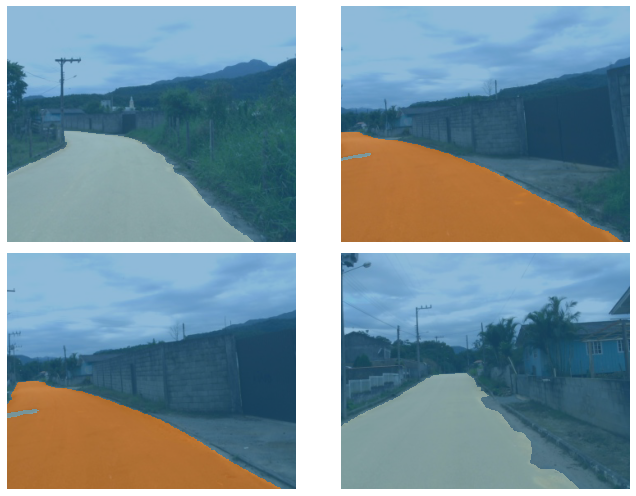

In [ ]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
data.show_batch(2, figsize=(10,10))
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

3.2. First step Model

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,acc_rtk,time
0,1.659850,1.075615,0.030304,02:18
1,0.910944,0.631639,0.426537,02:00
2,0.596707,0.452211,0.638970,02:00
3,0.393620,0.305818,0.789735,02:00
4,0.316850,0.260803,0.845892,02:00
5,0.274429,0.230447,0.847753,02:00
6,0.223652,0.230576,0.860742,02:00
7,0.201508,0.182672,0.869829,02:00
8,0.184725,0.195198,0.870267,02:00
9,0.155366,0.142691,0.895237,02:00


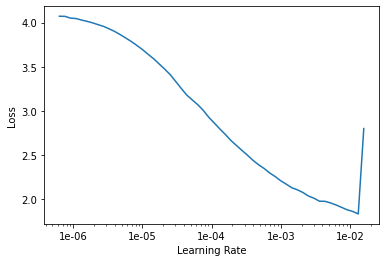

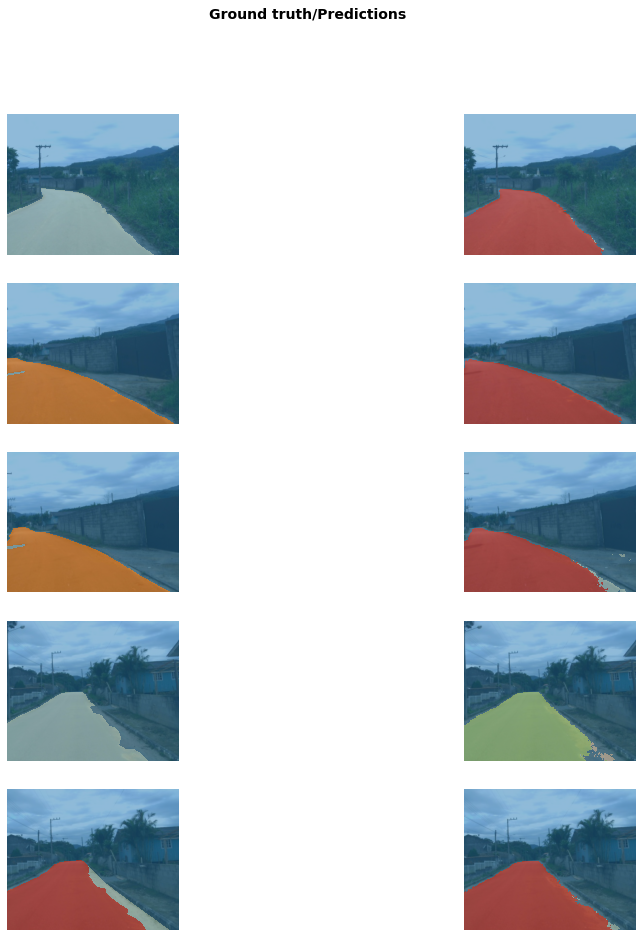

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}

def acc_rtk(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()
metrics=acc_rtk
wd=1e-2
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
#CUDA_LAUNCH_BLOCKING=1
lr_find(learn)
learn.recorder.plot()
lr=1e-4
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)
learn.save('stage-1')
learn.load('stage-1');
learn.show_results(rows=5, figsize=(15,15))

3.3. Interpret

tensor([ 67,  15,  69,  59, 115])

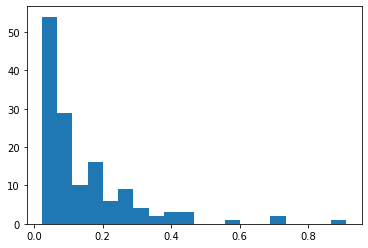

In [ ]:
interp = SegmentationInterpretation.from_learner(learn)
top_losses, top_idxs = interp.top_losses((288,352))
# plot loss distribution
plt.hist(to_np(top_losses), bins=20)
# top loss idxs of images
top_idxs[:5]

3.4. Confusion Matrix

label,score
background,0.990008
roadAsphalt,0.952602
roadPaved,0.818973
roadUnpaved,0.705806
roadMarking,0.564916
speedBump,0.0
catsEye,0.0
stormDrain,0.0
patchs,0.0
waterPuddle,0.0


label,score
background,0.99844
roadAsphalt,0.977667
roadMarking,0.465855
stormDrain,0.0
patchs,0.0
craks,0.0
roadPaved,NaN
roadUnpaved,NaN
speedBump,NaN
catsEye,NaN


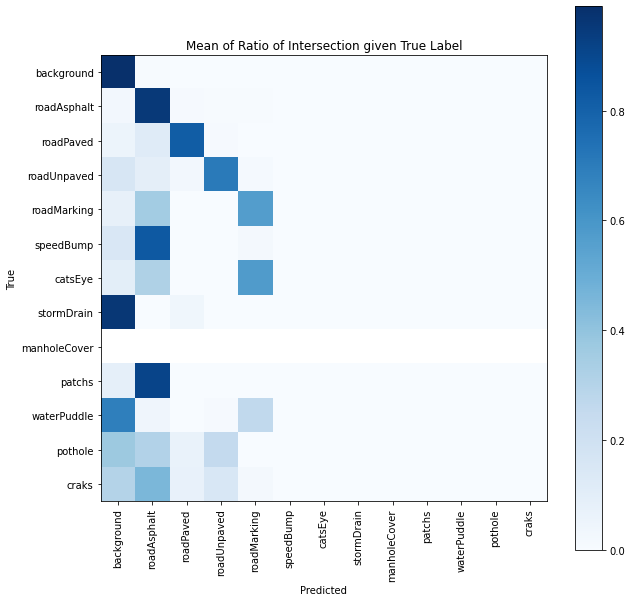

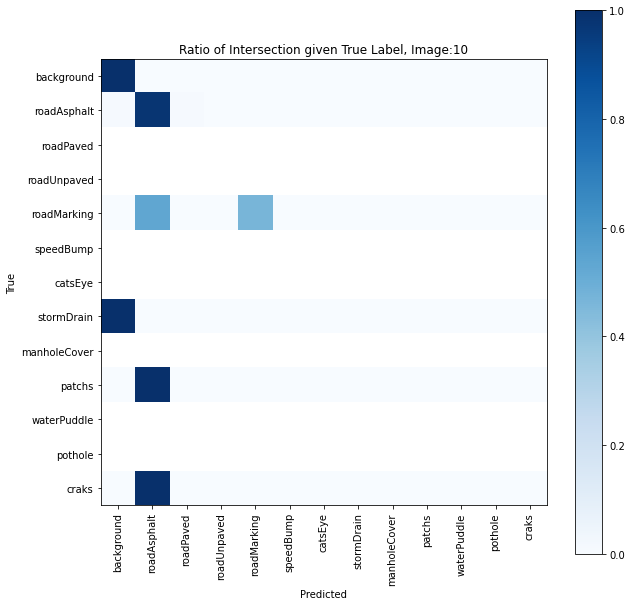

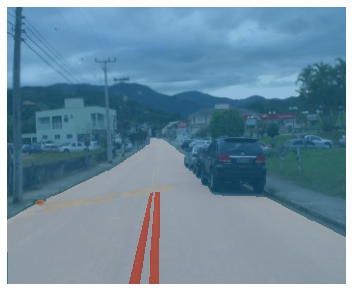

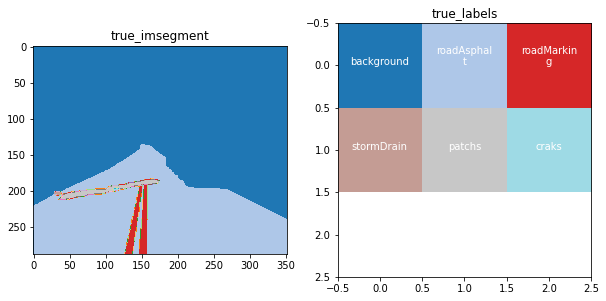

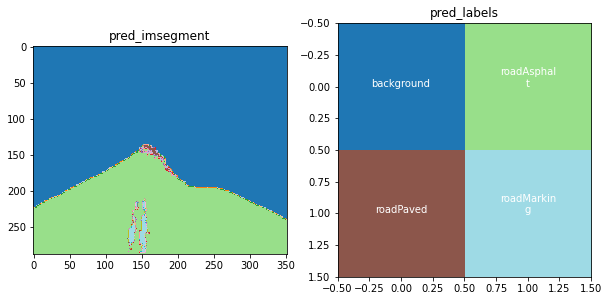

In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()
mean_cm.shape, single_img_cm.shape
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")
# single image class performance
i = 10
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")
# show xyz
interp.show_xyz(i)

3.5. First model continuation

epoch,train_loss,valid_loss,acc_rtk,time
0,0.119344,0.135440,0.907255,02:06
1,0.119410,0.134880,0.909461,02:05
2,0.117069,0.135390,0.909800,02:05
3,0.114043,0.133317,0.910652,02:05
4,0.112425,0.133831,0.905711,02:05
5,0.113038,0.129672,0.910234,02:05
6,0.110440,0.130292,0.912486,02:05
7,0.110233,0.130186,0.907723,02:05
8,0.110072,0.129253,0.906075,02:05
9,0.107404,0.126227,0.910983,02:05


epoch,train_loss,valid_loss,acc_rtk,time
0,0.119344,0.135440,0.907255,02:06
1,0.119410,0.134880,0.909461,02:05
2,0.117069,0.135390,0.909800,02:05
3,0.114043,0.133317,0.910652,02:05
4,0.112425,0.133831,0.905711,02:05
5,0.113038,0.129672,0.910234,02:05
6,0.110440,0.130292,0.912486,02:05
7,0.110233,0.130186,0.907723,02:05
8,0.110072,0.129253,0.906075,02:05
9,0.107404,0.126227,0.910983,02:05


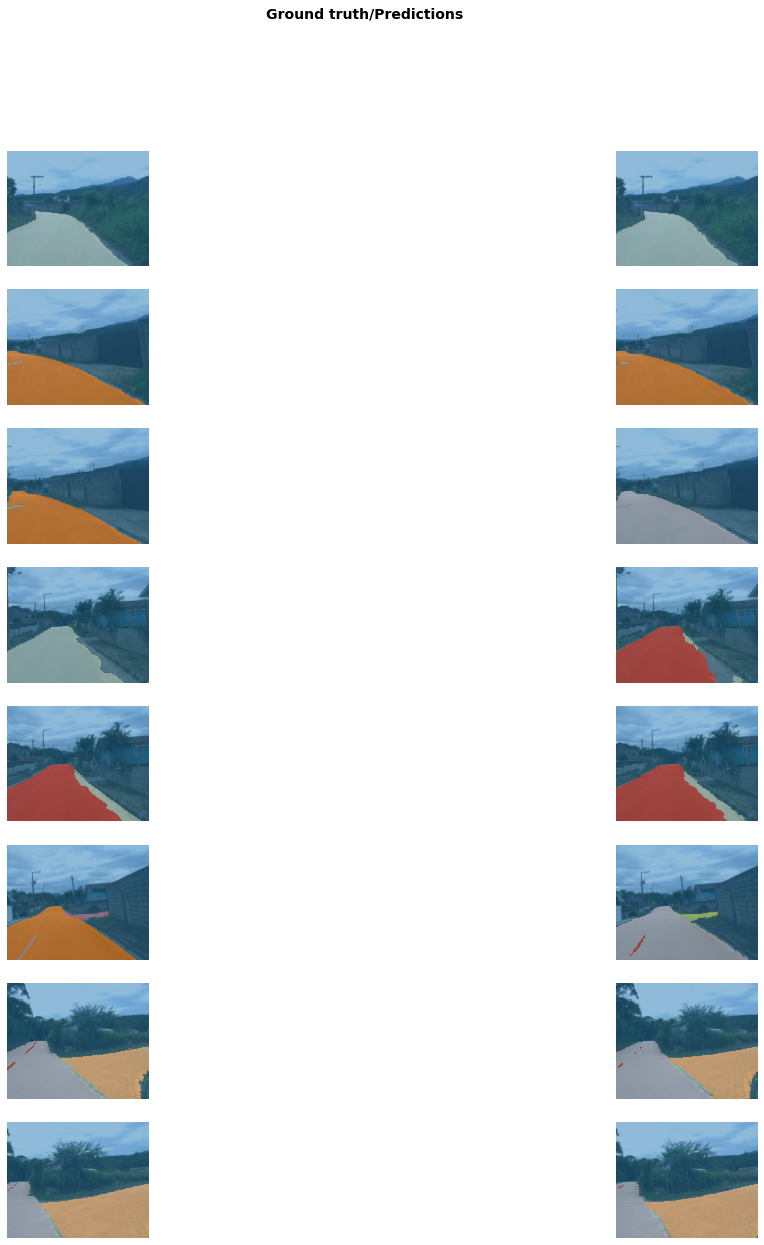

In [ ]:
learn.unfreeze()
lrs = slice(lr/400,lr/4)
learn.fit_one_cycle(100, lrs, pct_start=0.9)
learn.save('stage-2')
learn.load('stage-2');
learn.show_results(rows=25, figsize=(20,20))

3.6. Confusion Matrix

label,score
background,0.991898
roadAsphalt,0.968939
roadPaved,0.928812
roadUnpaved,0.883874
roadMarking,0.737064
patchs,0.589183
speedBump,0.53435
pothole,0.471306
waterPuddle,0.425278
stormDrain,0.421502


label,score
background,0.998185
roadAsphalt,0.991795
roadPaved,NaN
roadUnpaved,NaN
roadMarking,NaN
speedBump,NaN
catsEye,NaN
stormDrain,NaN
manholeCover,NaN
patchs,NaN


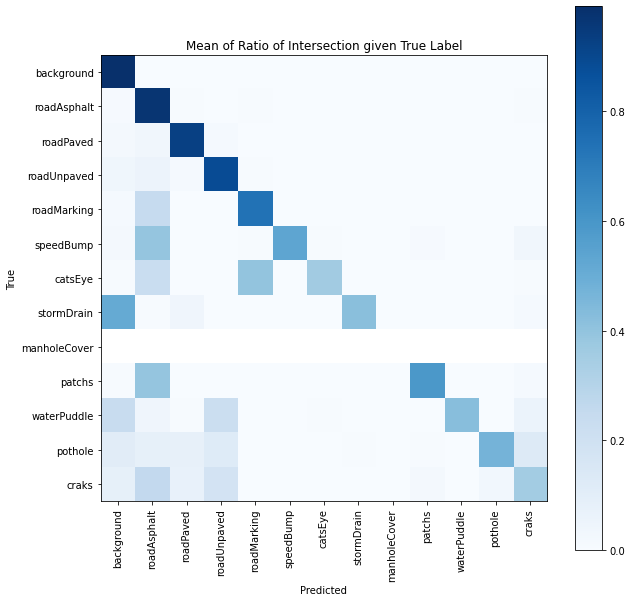

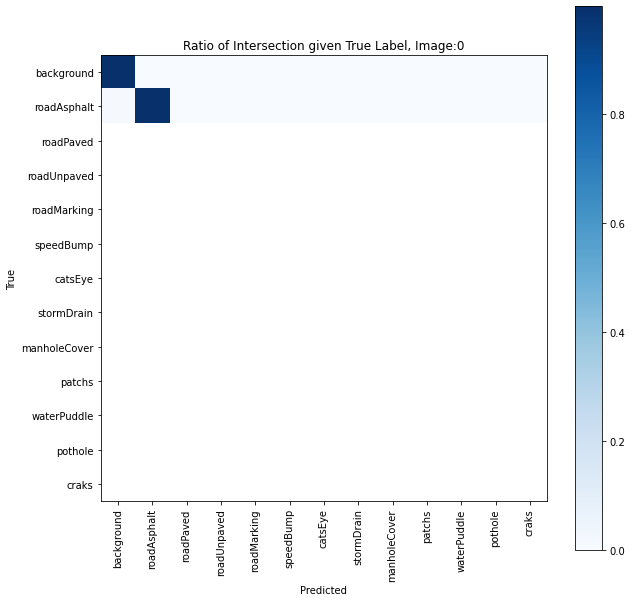

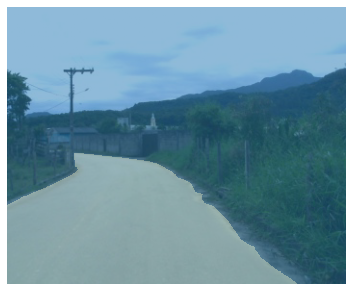

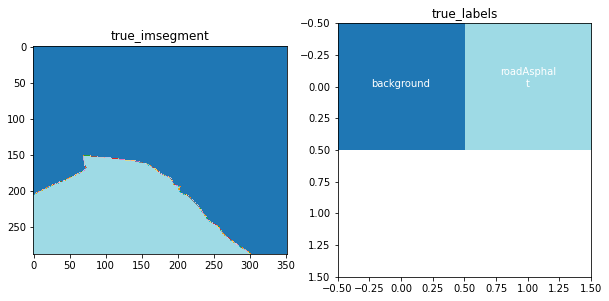

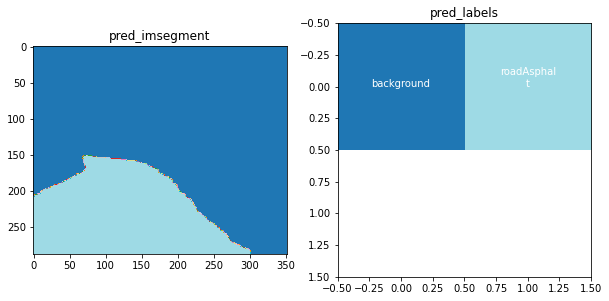

In [ ]:
interp = SegmentationInterpretation.from_learner(learn)
mean_cm, single_img_cm = interp._generate_confusion()
mean_cm.shape, single_img_cm.shape
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")
# single image class performance
i = 0
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")
# show xyz
interp.show_xyz(i)

3.7. Interpret

In [ ]:
learn.interpret

3.8. Saving

In [ ]:
learn.save('stage-2')
data=None
learn=None
gc.collect()

52200

4. Second Step - With weights

4.1. Second step Datasets

using bs=8, have 11438MB of GPU RAM free


/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:859.)
  return _solve_func(B,A)[0][:,0]


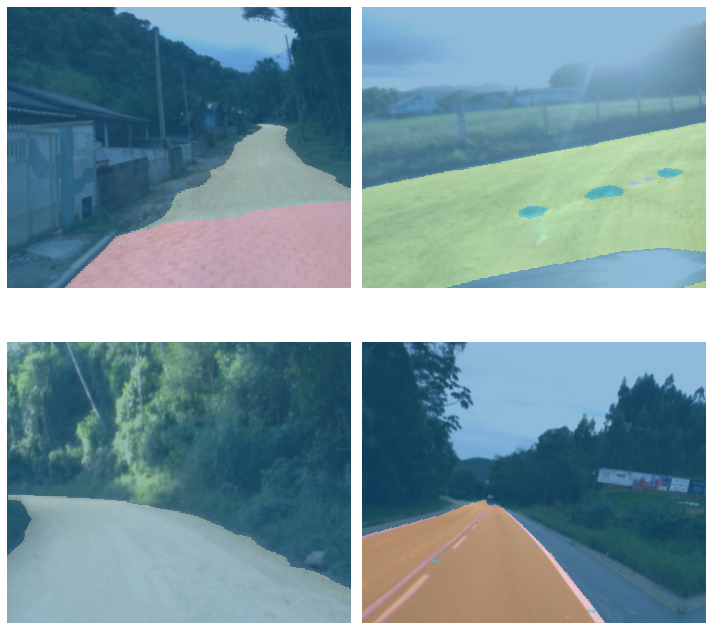

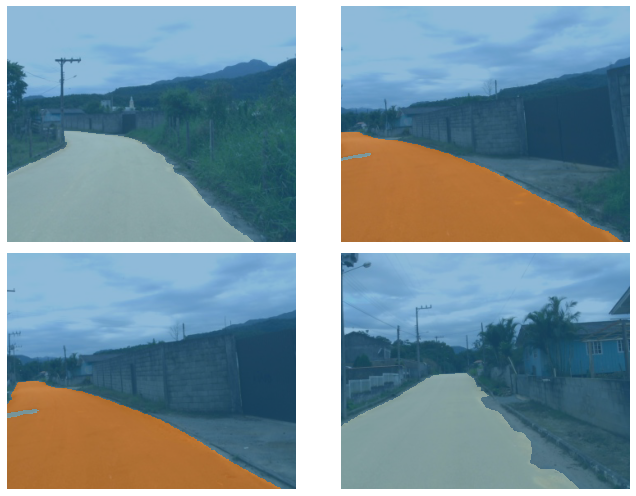

In [ ]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
data.show_batch(2, figsize=(10,10))
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

4.2. Second step Model

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Thu May  5 17:57:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    69W / 149W |   1471MiB / 11441MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

epoch,train_loss,valid_loss,acc_rtk,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,acc_rtk,time
0,0.257185,0.322672,0.961322,02:12
1,0.227925,0.293363,0.965834,01:59
2,0.201682,0.305438,0.957087,01:59
3,0.274773,0.458651,0.921876,01:59
4,0.356882,0.658845,0.961071,01:59
5,0.452822,0.453005,0.933192,01:59
6,0.338921,0.340562,0.940786,01:58
7,0.496112,0.592867,0.930978,01:59
8,0.459722,0.418005,0.910487,01:58
9,0.283089,0.248596,0.940380,01:58


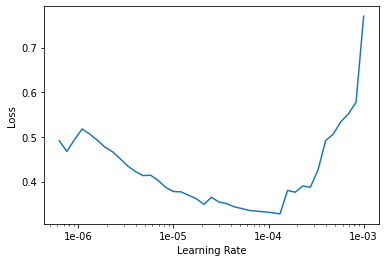

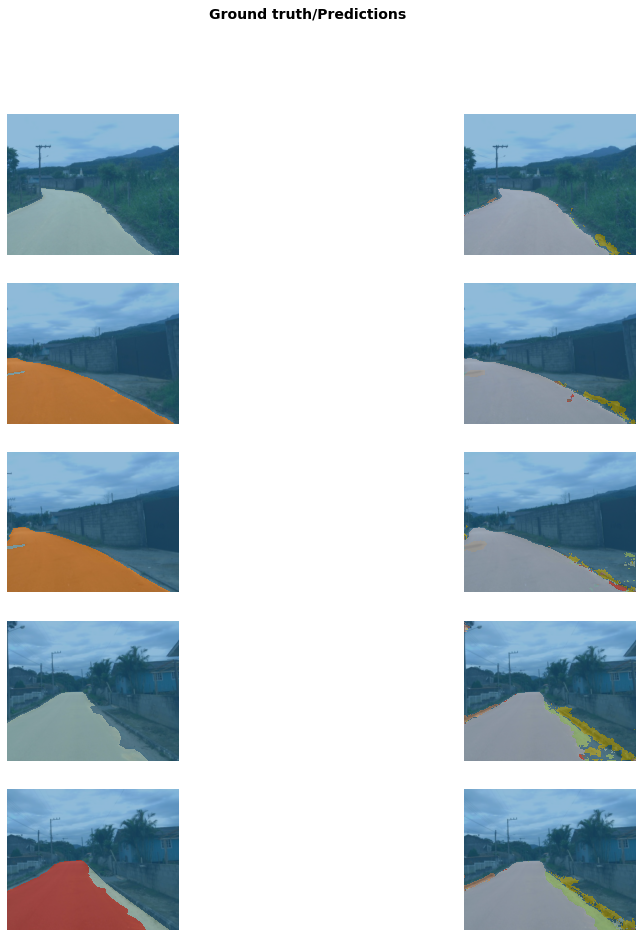

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['manholeCover']

def acc_rtk(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()
metrics=acc_rtk
wd=1e-2
balanced_loss = CrossEntropyFlat(axis=1, weight=torch.tensor([1.0,5.0,6.0,7.0,75.0,1000.0,3100.0,3300.0,0.0,270.0,2200.0,1000.0,180.0]).cuda())
learn = unet_learner(data, models.resnet34, metrics=metrics, loss_func=balanced_loss, wd=wd)
learn.load('stage-2')
!/opt/bin/nvidia-smi
#CUDA_LAUNCH_BLOCKING=1
lr_find(learn)
learn.recorder.plot()
lr=1e-4
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)
learn.save('stage-1-weights')
learn.load('stage-1-weights');
learn.show_results(rows=5, figsize=(15,15))

4.3. Interpret

tensor([115,  11,  67,  68,  56])

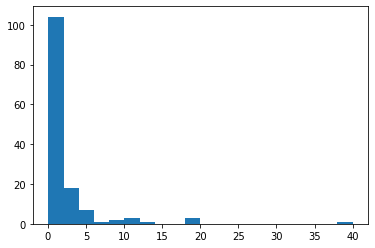

In [ ]:
interp = SegmentationInterpretation.from_learner(learn)
top_losses, top_idxs = interp.top_losses((288,352))
# plot loss distribution
plt.hist(to_np(top_losses), bins=20)
# top loss idxs of images
top_idxs[:5]

4.4. Confusion Matrix

label,score
stormDrain,0.993431
waterPuddle,0.978287
background,0.951436
catsEye,0.94817
roadPaved,0.900629
patchs,0.880488
roadMarking,0.870996
roadAsphalt,0.853387
roadUnpaved,0.849268
pothole,0.774518


label,score
background,0.985357
roadAsphalt,0.950681
patchs,0.943723
stormDrain,0.901961
roadMarking,0.827586
craks,0.0
roadPaved,NaN
roadUnpaved,NaN
speedBump,NaN
catsEye,NaN


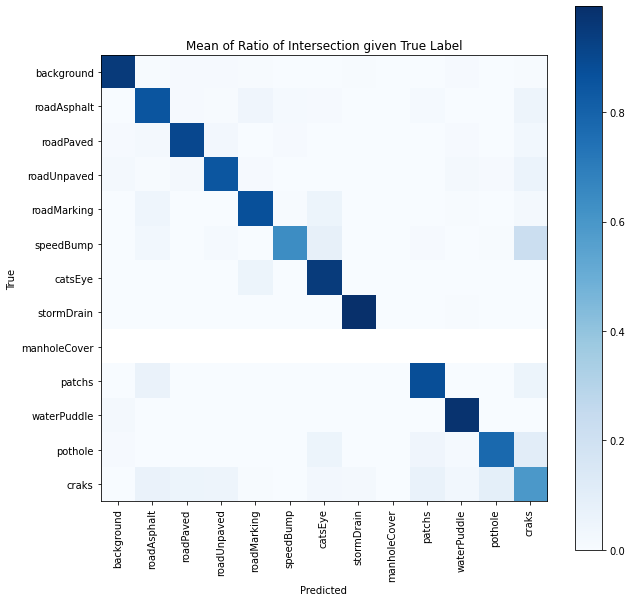

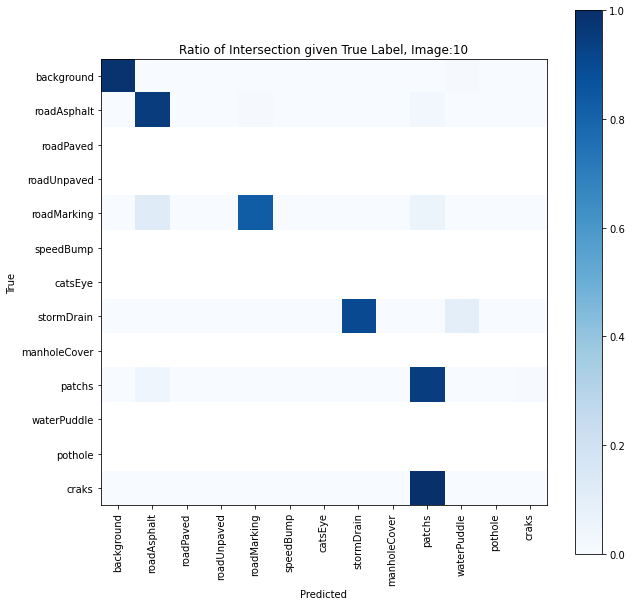

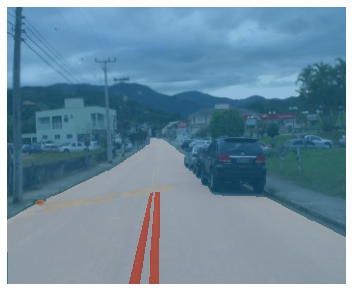

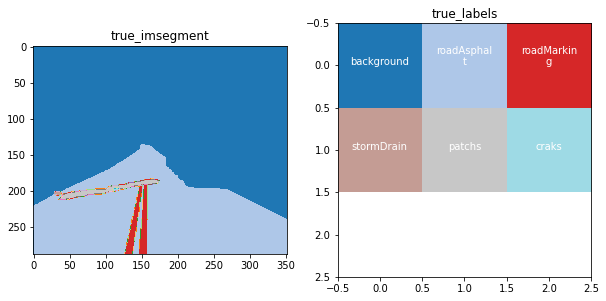

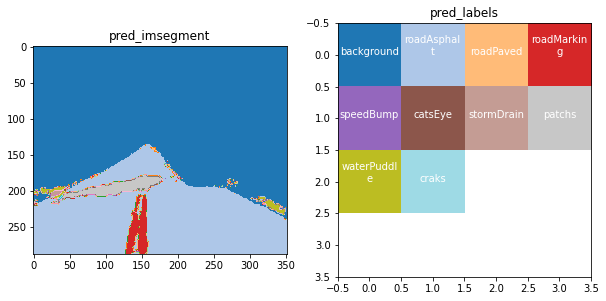

In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()
mean_cm.shape, single_img_cm.shape
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")
# single image class performance
i = 10
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")
# show xyz
interp.show_xyz(i)

4.5. Second model continuation

In [ ]:
learn.unfreeze()
lrs = slice(lr/400,lr/4)
learn.fit_one_cycle(100, lrs, pct_start=0.8)
learn.save('stage-2-weights')
learn.load('stage-2-weights');
learn.show_results(rows=25, figsize=(20,20))

NameError: ignored

4.6. Confusion Matrix

In [ ]:
interp = SegmentationInterpretation.from_learner(learn)
mean_cm, single_img_cm = interp._generate_confusion()
mean_cm.shape, single_img_cm.shape
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")
# single image class performance
i = 130
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")
# show xyz
interp.show_xyz(i)

NameError: ignored

4.7. Interpret

In [ ]:
learn.interpret

NameError: ignored

4.8. Saving

In [ ]:
learn.save('stage-2-weights')

5. Using a saved model to Predict

In [ ]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
learn = unet_learner(data, models.resnet34)
learn.load('stage-2-weights');
interp = SegmentationInterpretation.from_learner(learn)
mean_cm, single_img_cm = interp._generate_confusion()
mean_cm.shape, single_img_cm.shape
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")
# single image class performance
i = 130
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")
# show xyz
interp.show_xyz(i)
learn.show_results()

using bs=4, have 0MB of GPU RAM free


/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:859.)
  return _solve_func(B,A)[0][:,0]
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

FileNotFoundError: ignored

6. Saving the Results

In [ ]:
img_f = fnames[655]
img = open_image(img_f)
img.show(figsize=(5,5))
prediction = learn.predict(img)
prediction[0].show(figsize=(5,5))
results_save = 'results'
path_rst = path/results_save
path_rst.mkdir(exist_ok=True)
def save_preds(names):
    i=0
    #names = dl.dataset.items
    
    for b in names:
        img_s = fnames[i]
        img_toSave = open_image(img_s)
        img_split = f'{img_s}'
        img_split = img_split[44:]
        predictionSave = learn.predict(img_toSave)
        predictionSave[0].save(path_rst/img_split) #Save Image
        i += 1
        print(i)
save_preds(fnames)

7. Coloring the Results

In [ ]:
import os
import glob
import base64
import cv2 as cv
cv.__version__
colored_results = 'results_color'
path_crst = path/colored_results
path_crst.mkdir(exist_ok=True)
%load_ext cython
%%cython -a
import cython
cimport numpy
import cv2 as cv
import numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
#def colorfull_fast(numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] frame):
cpdef numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] colorfull_fast(numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] frame):
  # set the variable extension types
  cdef int x, y, width, height, b, g, r

  #frame = cv.imdecode(np.frombuffer(byteframe, np.uint8), -1)

  # grab the image dimensions
  width = 288
  height = 352
    
  # loop over the image, pixel by pixel
  for x in range(width):
    for y in range(height):
      b, g, r = frame[x, y]
      if (b, g, r) == (0,0,0): #background
        frame[x, y] = (0,0,0)
      elif (b, g, r) == (1,1,1): #roadAsphalt
        frame[x, y] = (85,85,255)
      elif (b, g, r) == (2,2,2): #roadPaved
        frame[x, y] = (85,170,127)
      elif (b, g, r) == (3,3,3): #roadUnpaved
        frame[x, y] = (255,170,127) 
      elif (b, g, r) == (4,4,4): #roadMarking
        frame[x, y] = (255,255,255) 
      elif (b, g, r) == (5,5,5): #speedBump
        frame[x, y] = (255,85,255)
      elif (b, g, r) == (6,6,6): #catsEye
        frame[x, y] = (255,255,127)          
      elif (b, g, r) == (7,7,7): #stormDrain
        frame[x, y] = (170,0,127) 
      elif (b, g, r) == (8,8,8): #manholeCover
        frame[x, y] = (0,255,255) 
      elif (b, g, r) == (9,9,9): #patchs
        frame[x, y] = (0,0,127) 
      elif (b, g, r) == (10,10,10): #waterPuddle
        frame[x, y] = (170,0,0)
      elif (b, g, r) == (11,11,11): #pothole
        frame[x, y] = (255,0,0)
      elif (b, g, r) == (12,12,12): #cracks
        frame[x, y] = (255,85,0)
 
  frame = cv.cvtColor(frame,cv.COLOR_BGR2RGB)
  
  # return the colored image
  return frame
import timeit
# Count variables
fqtd = 0

filenames = [img for img in glob.glob(str(path_rst/"*.png"))]

filenames.sort() # ADD THIS LINE

for img in filenames:
  frame = cv.imread(img)

  #%timeit colorfull_fast(frame)
  
  frame = colorfull_fast(frame)
  name = "%09d.png"%fqtd
  cv.imwrite(os.path.join(path_crst, name), frame)

  fqtd += 1
  print(fqtd)

print("Done!")